Materials:  


**Table of contents**<a id='toc0_'></a>    
- [Сonnecting to DB, creating tables](#toc1_)    
- [DB inspector](#toc2_)    
- [Data generation](#toc3_)    
- [Saving data to DB](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# For data manipulations
import pandas as pd

# Work with DB
import os
from sqlalchemy import create_engine
from sqlalchemy import text
from sqlalchemy import URL
from sqlalchemy.inspection import inspect

# Data generation
import random
from datetime import datetime
from faker import Faker
from faker.providers import BaseProvider

# <a id='toc1_'></a>[Сonnecting to DB, creating tables](#toc0_)

Connect to movie DB with engine (for Postgres DB you need to install the `psycopg2`).  
My parameters for connecting to DB are stored in a file `.env` (virtual environment).

In [2]:
host = 'host'
port = 'port'
user = 'user'
password = 'password'
db = 'db'

url_object = URL.create('postgresql',
                        username=os.getenv(user),
                        password=os.getenv(password),
                        host=os.getenv(host),
                        port=os.getenv(port),
                        database=os.getenv(db))

engine = create_engine(url_object)

Сreate tables in movie DB, data schema based on [this task](https://www.codewars.com/kata/5818bde9559ff58bd90004a2/sql).

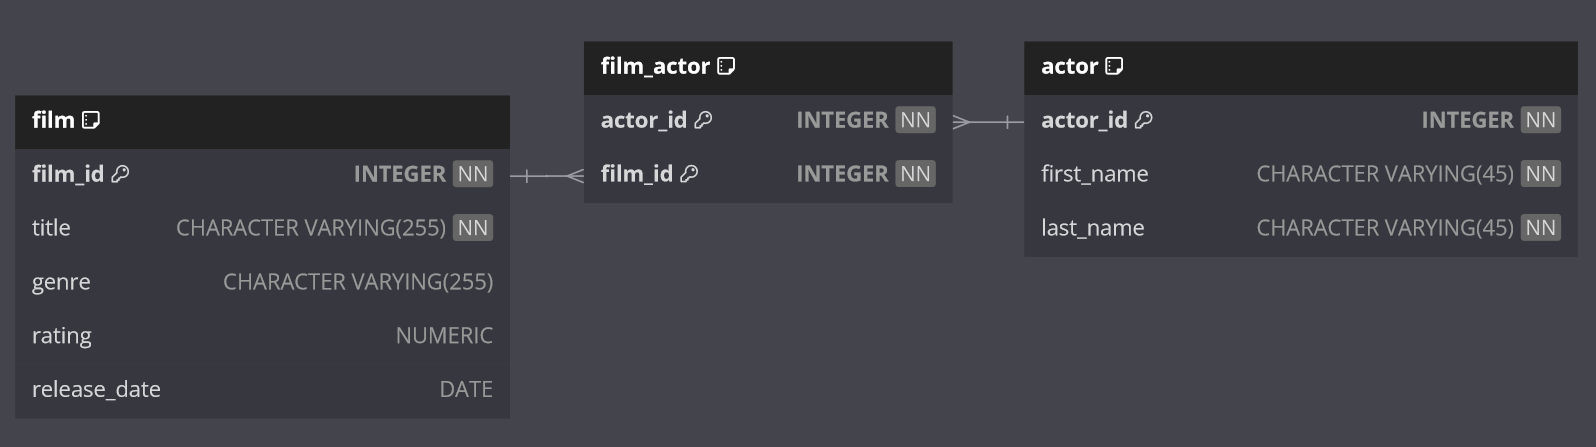

In [3]:
query = """-- sql
CREATE TABLE film (
  film_id INTEGER NOT NULL,
  title CHARACTER VARYING(255) NOT NULL,
  genre CHARACTER VARYING(255),
  rating NUMERIC,
  release_date DATE,
  PRIMARY KEY (film_id)
);

CREATE TABLE actor (
  actor_id INTEGER NOT NULL,
  first_name CHARACTER VARYING(45) NOT NULL,
  last_name CHARACTER VARYING(45) NOT NULL,
  PRIMARY KEY (actor_id)
);

CREATE TABLE film_actor (
  actor_id INTEGER NOT NULL,
  film_id INTEGER NOT NULL,
  PRIMARY KEY (actor_id, film_id),
  FOREIGN KEY (actor_id) REFERENCES actor (actor_id),
  FOREIGN KEY (film_id) REFERENCES film (film_id)
);
"""
with engine.connect() as conn:
    conn.execute(text(query))
    conn.commit()

# <a id='toc2_'></a>[DB inspector](#toc0_)

Define an inspector of DB and check it's some useful features

In [4]:
insp = inspect(engine)

In [5]:
# Default schema
insp.default_schema_name

'public'

In [6]:
# Available get-methods for working with schema
get_methods = [x for x in dir(insp) if x.startswith('get')]
get_methods

['get_check_constraints',
 'get_columns',
 'get_domains',
 'get_enums',
 'get_foreign_keys',
 'get_foreign_table_names',
 'get_indexes',
 'get_materialized_view_names',
 'get_multi_check_constraints',
 'get_multi_columns',
 'get_multi_foreign_keys',
 'get_multi_indexes',
 'get_multi_pk_constraint',
 'get_multi_table_comment',
 'get_multi_table_options',
 'get_multi_unique_constraints',
 'get_pk_constraint',
 'get_schema_names',
 'get_sequence_names',
 'get_sorted_table_and_fkc_names',
 'get_table_comment',
 'get_table_names',
 'get_table_oid',
 'get_table_options',
 'get_temp_table_names',
 'get_temp_view_names',
 'get_unique_constraints',
 'get_view_definition',
 'get_view_names']

In [7]:
# Table names of movie DB
insp.get_table_names()

['actor', 'film_actor', 'film']

In [8]:
# Data types of actor table
pd.DataFrame(insp.get_columns('actor'))

,name,type,nullable,default,autoincrement,comment
0,actor_id,INTEGER,False,None,False,None
1,first_name,VARCHAR(45),False,None,False,None
2,last_name,VARCHAR(45),False,None,False,None


In [9]:
# PK of actor table
insp.get_pk_constraint('actor')

{'constrained_columns': ['actor_id'], 'name': 'actor_pkey', 'comment': None}

In [10]:
# FK of film_actor table
insp.get_foreign_keys('film_actor')

[{'name': 'film_actor_actor_id_fkey',
  'constrained_columns': ['actor_id'],
  'referred_schema': None,
  'referred_table': 'actor',
  'referred_columns': ['actor_id'],
  'options': {},
  'comment': None},
 {'name': 'film_actor_film_id_fkey',
  'constrained_columns': ['film_id'],
  'referred_schema': None,
  'referred_table': 'film',
  'referred_columns': ['film_id'],
  'options': {},
  'comment': None}]

# <a id='toc3_'></a>[Data generating](#toc0_)

Get some real looking data using the fake data provider Faker.

In [11]:
# Initialize the Faker object
fake = Faker()

In [12]:
type(fake)

faker.proxy.Faker

In [13]:
# Example of random profile
fake.profile()

{'job': 'Fast food restaurant manager',
 'company': 'Smith, Williams and Lynn',
 'ssn': '771-04-9061',
 'residence': '5058 Garcia Hill Suite 790\nLake Stevenburgh, IN 90731',
 'current_location': (Decimal('73.507572'), Decimal('-33.275983')),
 'blood_group': 'AB+',
 'website': ['https://www.roth.com/',
  'https://www.black.com/',
  'https://www.smith.net/'],
 'username': 'dmiranda',
 'name': 'Nicholas Davis',
 'sex': 'M',
 'address': '98796 Joy Fords\nEast Jennifer, SD 56409',
 'mail': 'jonathanhenry@yahoo.com',
 'birthdate': datetime.date(1921, 1, 1)}

## Data configuration

In [14]:
AMOUNT_FILMS = 100
AMOUNT_ACTORS = 3 * AMOUNT_FILMS

print('''
Generating fake data for
- %d films, 
- %d actors
''' % (AMOUNT_FILMS, AMOUNT_ACTORS))


Generating fake data for
- 100 films, 
- 300 actors



## `actor` table

In [15]:
# Structure of actor table
pd.DataFrame(insp.get_columns('actor'))

,name,type,nullable,default,autoincrement,comment
0,actor_id,INTEGER,False,None,False,None
1,first_name,VARCHAR(45),False,None,False,None
2,last_name,VARCHAR(45),False,None,False,None


In [16]:
# Filling of index (actor_id PK) from 1 to AMOUNT_ACTORS
actor = pd.DataFrame(index=range(1, AMOUNT_ACTORS + 1))
actor.index.name ='actor_id'

# Data generating for first_name and last_name
actor['first_name'] = actor.index.map(lambda x : fake.first_name())
actor['last_name'] = actor.index.map(lambda x : fake.last_name())

In [17]:
actor.head()

,first_name,last_name
actor_id,,
1,Paul,Vincent
2,Andrew,Smith
3,Toni,Blair
4,Anthony,Mendez
5,Barbara,Young


## `film` table

In [18]:
# Structure of film table
pd.DataFrame(insp.get_columns('film'))

,name,type,nullable,default,autoincrement,comment
0,film_id,INTEGER,False,None,False,None
1,title,VARCHAR(255),False,None,False,None
2,genre,VARCHAR(255),True,None,False,None
3,rating,NUMERIC,True,None,False,None
4,release_date,DATE,True,None,False,None


In [19]:
# Index filling (film_id PK)
film = pd.DataFrame(index=range(1, AMOUNT_FILMS + 1))
film.index.name = 'film_id'

You can create your own provider for some data:

In [35]:
# Create new provider class film.genre
class GenereProvider(BaseProvider):
    def film_genre(self):
        return random.choice(['Documentary', 'Thriller', 'Mystery',
                              'Horror', 'Action', 'Comedy', 'Drama', 'Romance'])

# Add new provider to Faker instance
fake.add_provider(GenereProvider)

In [36]:
# Get film.title
def get_film_title():
    words = fake.words()   # Returns 3 words
    capitalized_words = list(map(lambda x: x.capitalize(), words))
    return ' '.join(capitalized_words)


# Get film.rating [1.0, 10.0)
def get_film_rating():
    return round(random.uniform(1.0, 10.0), 1)


# Get film.date
def get_film_date():
    return datetime.strftime(fake.date_time_this_decade(), '%Y-%m-%d')

In [37]:
# Data generating for film table
film['title'] = film.index.map(lambda x: get_film_title())
film['genre'] = film.index.map(lambda x: fake.film_genre())
film['rating'] = film.index.map(lambda x: get_film_rating())
film['release_date'] = film.index.map(lambda x: get_film_date())

In [38]:
film.head()

,title,genre,rating,release_date
film_id,,,,
1,Make Box Morning,Horror,1.7,2021-07-20
2,Read Ground Never,Thriller,4.3,2022-11-19
3,Factor Media Well,Documentary,5.0,2023-09-07
4,Great Discuss Really,Romance,1.7,2021-05-30
5,Outside Those Occur,Thriller,7.2,2021-11-23


## `film_actor` table

In [39]:
# Structure of film_actor table
pd.DataFrame(insp.get_columns('film_actor'))

,name,type,nullable,default,autoincrement,comment
0,actor_id,INTEGER,False,None,False,None
1,film_id,INTEGER,False,None,False,None


Get already existing entries (`actor_id` and `film_id`) from `actor` and `film` tables.  
Put initial film_actor len like `n x m = 30 000 rows`.

In [40]:
# Filling film_actor.film_id from film.film_id
film_actor = pd.DataFrame(index=film.sample(len(actor) * len(film),
                                            replace=True).index)

film_actor.index.name = 'film_id'

# Filling film_actor.actor_id from actor.actor_id

""
film_id
69
72
58
45
7


In [43]:
# Заполняем actor_id (индексы от 1 до 300)
film_actor_tmp['actor_id'] = actor.sample(len(film_actor_tmp), replace=True).index

# Задаем actor_id как индекс
film_actor_tmp = film_actor_tmp.set_index([film_actor_tmp.index, 'actor_id'])

In [44]:
len(film_actor_tmp)

30000

In [45]:
# Проверяем на дубли и сохраняем корректные индексы (без дублей) в df
film_actor = pd.DataFrame(index=pd.MultiIndex.from_tuples(film_actor_tmp.index.unique()))
film_actor.index.names = ['film_id', 'actor_id']

film_actor.sample(5)

,
film_id,actor_id
71,108
8,109
65,299
68,137
4,233


In [46]:
# Было 30 000 строк -- осталось около 20 000
len(film_actor)

18984

# <a id='toc4_'></a>[Saving data to DB](#toc0_)